# Task 2

Task 2: You are free to find and define a problem (apply the discovery and define phases first, from the UK Design Council Double Diamond, 3.007 Design Thinking and Innovation) of your interest related to COVID-19. The problem can be modelled either using Linear Regression (or Multiple Linear Regression) or Logistic Regression, which means you can work with either continuous numerical data or classification.

The following technical/tool constraint applies: you are NOT allowed to use Neural Networks or other Machine Learning models. You must use Python and Jupyter Notebook.

In general, you may want to consider performing the following steps:
- Find an interesting problem which you want to solve either using **Linear Regression or Classification** (please check with your instructors first on whether the problem makes sense).
- Find a **dataset** to build your model. For example, you can use Kaggle (https://www.kaggle.com/datasets) to find suitable datasets.
- Use **plots** to visualize and understand your data.
- Create **training and test** data sets.
- Build your model.
- Choose an **appropriate metric** to evaluate your model (you may use the same metric as the one used in Task 1).
- Improve your model.

Problem: predict gold prices given covid
Effect of covid on economy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load data 
We use data from [Yahoo Finance](https://finance.yahoo.com/quote/GLD/history?period1=1479859200&period2=1637625600&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true) 

In [3]:
df_gold_all = pd.read_csv('GLD.csv')
df = pd.read_csv('covid_data.csv')

# display(df_gold_all)
# display(df)


## Clean data

In [4]:
# Clean covid data by selecting only the relevant columns

df_subset = df.loc[((df['location']=='United States')| (df['location']=='China') | (df['location']=='Japan') | (df['location']=='Hong Kong') | (df['location']=='United Kingdom') | 
(df['location']=='Canada') | (df['location']=='India') | (df['location']=='Saudi Arabia') | (df['location']=='France') | (df['location']=='Germany') | 
(df['location']=='South Korea') | (df['location']=='Switzerland') | (df['location']=='Australia') | (df['location']=='Netherlands') |  
(df['location']=='Iran')| (df['location']=='Sweden')| (df['location']=='Brazil')| (df['location']=='Spain')|(df['location']=='Russia') |(df['location']=='Singapore')) ,:]


In [5]:
# Fill any NaN values
df_covid=df_subset.fillna(0)
# display(df_covid.index)

In [6]:
# Change the 'date' column to DateTime object
df_covid['Week']=pd.to_datetime(df_covid['date'])

# Group by week and then take the mean for the week
df_covid=df_covid.groupby(pd.Grouper(key='Week', freq="W-MON")).mean()

# Exclude the last week to match up with gold data
df_covid=df_covid.iloc[:95,:]
# display(df_covid)


In [7]:
# Clean Up of Gold Data frame
# change to standard date 

df_gold_all = pd.read_csv('GLD.csv')

# Change gold date range to same range as covid date range
df_gold=df_gold_all.copy()
df_gold=df_gold.loc[((df_gold['Date']> '2020-01-26') & (df_gold['Date']< '2021-11-17')) ,:]

# Change the date column to DateTime Index
df_gold['Date'] = pd.to_datetime(df_gold['Date']).dt.date

In [9]:
# Sync up the indexing for both df_gold and df_covid
df_covid=df_covid.reset_index()
df_gold=df_gold.reset_index()

# Merge into one data frame
frames=[df_gold,df_covid]
df_all = pd.concat(frames,axis=1)
# display(df_all)

# Remove duplicated/unecessary columns
df_all.drop(['index','Week'], axis=1, inplace=True)
# display(df_all)

In [10]:
# Clean covid data by selecting only the relevant columns
# split data into numerical and categorical set so that we can normalize the numerical set
columns_cat=['Date']
columns_num=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients','Open','High','Low','Close','Adj Close','Volume']

df_cat = df_all.loc[:,columns_cat]

df_num = df_all.loc[:,columns_num]

# display(df_num)

def normalize_minmax(dfin):
    df_copy=dfin.copy()
    min_v=dfin.min(axis=0)
    max_v=dfin.max(axis=0)
    dfout=(df_copy-min_v)/(max_v-min_v)
    return dfout

def normalize_z(df):
    dfout=(df-df.mean(axis=0))/df.std(axis=0)
    return dfout

df_num_norm = normalize_z(df_num)
stats = df_num_norm.describe()
# display(stats)

frames=[df_cat , df_num_norm]
result = pd.concat(frames,axis=1)
df_covid=result.fillna(0)
# display(df_covid.index)

In [11]:
# Clean covid data by selecting only the relevant columns
columns=['Date','new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients','Open','High','Low','Close','Adj Close','Volume']

df_cov_gold = df_all.loc[:,columns]
df_cov_gold=df_cov_gold.fillna(0)
# display(df_cov_gold)

In [14]:
# display(df_cov_gold)
# df_cov_gold.isna().sum()

### Visualising data

In [15]:
# Clean covid data by selecting only the relevant columns
# split data into numerical and categorical set so that we can normalize the numerical set
columns_cat=['Date']
columns_num=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients','Open','High','Low','Close','Adj Close','Volume']

df_cat = df_all.loc[:,columns_cat]

df_num = df_all.loc[:,columns_num]

# display(df_num)

def normalize_minmax(dfin):
    df_copy=dfin.copy()
    min_v=dfin.min(axis=0)
    max_v=dfin.max(axis=0)
    dfout=(df_copy-min_v)/(max_v-min_v)
    return dfout

def normalize_z(df):
    dfout=(df-df.mean(axis=0))/df.std(axis=0)
    return dfout

df_num_norm = normalize_z(df_num)
stats = df_num_norm.describe()
# display(stats)

frames=[df_cat , df_num_norm]
df_visual = pd.concat(frames,axis=1)
df_visual=df_visual.fillna(0)


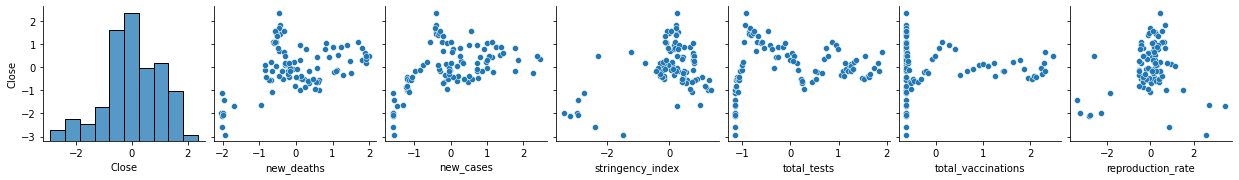

In [16]:
myplot = sns.pairplot(data=df_visual, x_vars=['Close','new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate'],y_vars=['Close'])

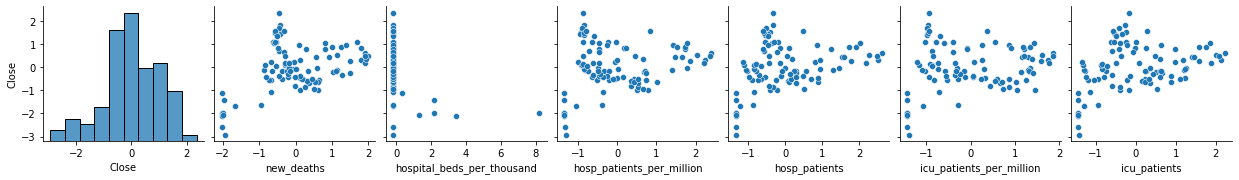

In [17]:
myplot = sns.pairplot(data=df_visual, x_vars=['Close','new_deaths','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients'],y_vars=['Close'])

### Train model

In [18]:
def normalize_minmax(dfin):
    df_copy=dfin.copy()
    min_v=dfin.min(axis=0)
    max_v=dfin.max(axis=0)
    dfout=(df_copy-min_v)/(max_v-min_v)
    return dfout

def normalize_z(df):
    dfout=(df-df.mean(axis=0))/df.std(axis=0)
    return dfout

def get_features_targets(df, feature_names, target_names):
    df_feature=df.loc[:,feature_names]
    df_target=df.loc[:,target_names]
    return df_feature, df_target

def compute_cost(X, y, beta):
    J = 0
    #calculate m, no of rows/data pt
    m = X.shape[0]
    
    #calculate yp, predicted target value from X and beta
    yp = np.matmul(X, beta)
    
    #calculate the error
    error = yp-y
    
    #calculate the cost
    J = (1/(2*m))*np.matmul(error.T, error)
    J= J[0][0] #to get the float
    return J

def prepare_feature(df_feature):
    #numpy is just arrays
    feature = df_feature.to_numpy()
    array1 = np.ones((feature.shape[0],1))
    X = np.concatenate((array1, feature), axis = 1)
    return X

def prepare_target(df_target):
    return df_target.to_numpy() 

def gradient_descent(X, y, beta, alpha, num_iters):
    #calculate m from shape of X or y
    m = X.shape[0]
    J_storage = np.zeros(num_iters)

    #for the number of iterations
    for n in range(num_iters):
        #--> compute the predicted y
        yp = np.matmul(X, beta)
        
        #--> compute the error
        error = yp - y
        
        #--> compute the new beta
        beta = beta - (alpha/m)*np.matmul(X.T, error)
        
        #--> compute J using the new beta and store it
        J_storage[n] = compute_cost(X, y, beta)
        
    return beta, J_storage

def predict_norm(X, beta):
    y = np.matmul(X, beta)
    return y

def predict(df_feature, beta):
    df_feature = normalize_z(df_feature)
    X = prepare_feature(df_feature)
    yp = predict_norm(X, beta)
    return yp

def mean_squared_error(target, pred):
    n=target.shape[0]
    error=target-pred
    mse=(1/n)*np.sum(error**2)
    return mse

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    indices=df_target.index

    if random_state!=None:
        np.random.seed(random_state)
    
    num_rows=len(indices)
    k = int(test_size * num_rows)
    test_indices=np.random.choice(indices,k,replace=False)

    indices=set(indices)
    test_indices=set(test_indices)
    train_indices=indices-test_indices
    
    df_feature_train=df_feature.loc[train_indices,:]
    df_feature_test=df_feature.loc[test_indices,:]
    df_target_train=df_target.loc[train_indices,:]
    df_target_test=df_target.loc[test_indices,:]
    return df_feature_train, df_feature_test, df_target_train, df_target_test

def r2_score(y, ypred):
    # calculate ssres
    diff = y - ypred
    ssres = np.matmul(diff.T, diff)[0][0]
    
    # calculate sstot
    ymean=np.mean(y)
    diff_mean=y-ymean #element wise subtraction
    sstot= np.matmul(diff_mean.T, diff_mean)[0][0]
    
    # calcuate r2
    return 1-(ssres/sstot)

def adj_r2_score(X,y,ypred):
    r2=r2_score(y, ypred)
    adj_r2=1 - ((1-r2)*(X.shape[0]-1)/(X.shape[0]-X.shape[1]-1))
    return adj_r2

In [31]:
# Get features and targets from data frame
features=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients']

df_feature, df_target = get_features_targets(df_cov_gold, features, ['Close'])
display(df_feature)
display(df_target)

# Split into training and test data set
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

# Normalize train features
df_features_train_z=normalize_z(df_features_train)
# display(df_features_train_z.describe())
# display(df_target_train.describe())

# Export same set of data to excel for excel analysis 
# frames1=[df_features_train_z, df_target_train]
# display(df_features_train_z)
# display(df_target_train)
# excel1 = pd.concat(frames1,axis=1)
# excel1 = excel1.fillna(0)
# display(excel1)
# excel1.to_excel("cov_gold_excel.xlsx")

# Prepare X and target vector
X = prepare_feature(df_features_train_z)
m=X.shape[1]
target = prepare_target(df_target_train)

# Set up gradient descent
iterations = 1500
alpha = 0.01
beta = np.zeros((m,1))

# Call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# Normal equation
X_sq=np.linalg.inv(np.matmul(X.T,X))
Xy=np.matmul(X.T,target)
beta_n= np.matmul(X_sq,Xy)



,new_deaths,new_cases,stringency_index,total_tests,total_vaccinations,reproduction_rate,hospital_beds_per_thousand,hosp_patients_per_million,hosp_patients,icu_patients_per_million,icu_patients
0,1.477273,53.477273,14.100909,3.568182e+00,0.000000e+00,0.375000,5.987500,0.002000,0.136364,0.000000,0.000000
1,3.853933,190.157303,16.485618,5.439326e+01,0.000000e+00,0.223483,5.018315,0.005494,0.370787,0.001517,0.101124
2,5.590476,216.228571,19.572857,9.919048e+01,0.000000e+00,0.116381,4.764000,0.008752,0.590476,0.000857,0.057143
3,8.133333,287.304762,19.978476,4.411333e+02,0.000000e+00,0.085524,4.764000,0.005219,0.352381,0.000286,0.019048
4,6.774775,52.171171,20.183423,1.102829e+03,0.000000e+00,0.241171,4.587568,0.002270,0.153153,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
90,191.471429,11407.221429,53.169429,8.688063e+07,2.274649e+08,0.938143,4.285500,26.957671,3599.057143,7.257300,1079.514286
91,193.078571,11422.700000,52.262714,8.994827e+07,2.343906e+08,0.984000,4.285500,27.200257,3362.207143,7.102771,1007.642857
92,190.264286,11694.685714,47.827643,8.947385e+07,2.331194e+08,1.019857,4.285500,27.753571,3198.550000,7.029236,917.557143
93,176.392857,11915.964286,42.060286,9.215567e+07,2.337482e+08,1.017429,4.285500,27.349979,3034.028571,6.782521,830.307143


,Close
0,149.330002
1,147.789993
2,149.000000
3,154.699997
4,148.380005
...,...
90,167.770004
91,166.649994
92,169.839996
93,174.449997


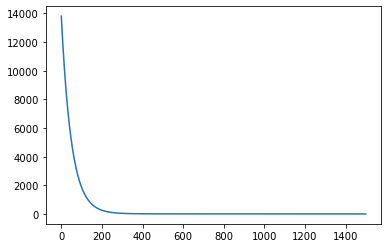

In [32]:
plt.plot(J_storage)

In [33]:
# Call the predict method to get the predicted values
pred = predict(df_features_test, beta)
with np.printoptions(threshold=np.inf):
    print(beta)

[[167.59532555]
 [  3.27480948]
 [  6.15421778]
 [  3.88627622]
 [ -1.50507384]
 [ -0.83803454]
 [ -1.93104515]
 [ -1.48844009]
 [ -2.25722964]
 [  2.92575393]
 [ -9.09312879]
 [  2.24138987]]


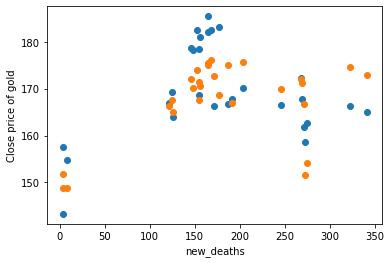

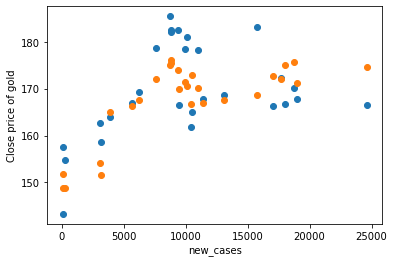

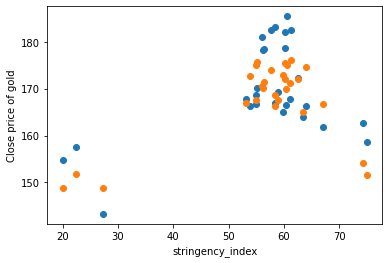

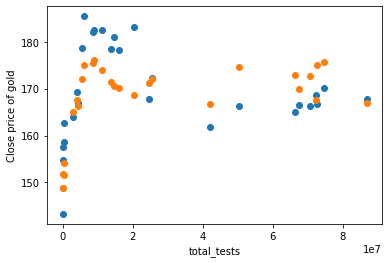

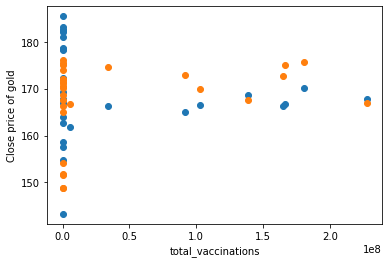

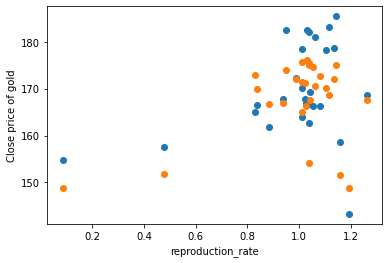

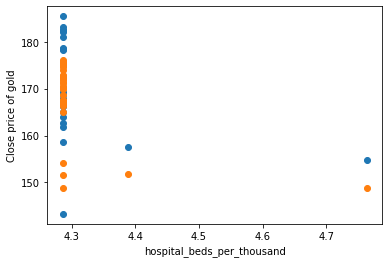

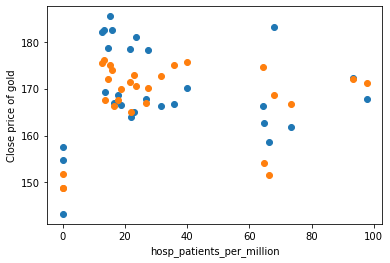

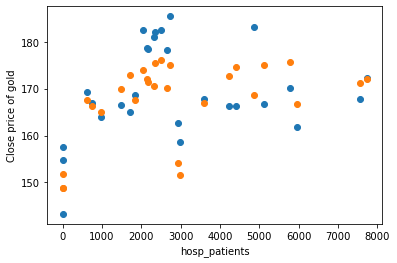

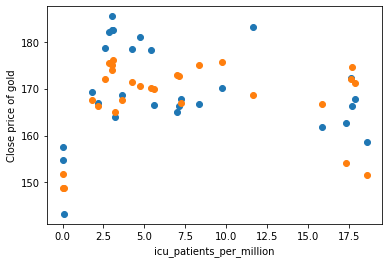

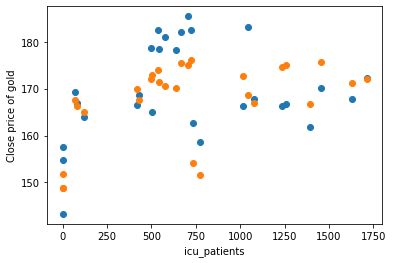

In [34]:
features=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients']
target = prepare_target(df_target_test)
for i in range(len(features)):
    ft=features[i]
    plt.figure(i)
    plt.scatter(df_features_test[ft],target)
    plt.scatter(df_features_test[ft],pred)
    plt.xlabel(ft)
    plt.ylabel('Close price of gold')

### Evaluate model

In [35]:
mse=mean_squared_error(target,pred)
print('MSE: ',mse)

rse=np.sqrt(mse/(X.shape[0]-m-1))
print('RSE: ',rse)

r2=r2_score(target, pred)
print('r2: ',r2)

adj_r2=adj_r2_score(df_features_test,target,pred)
print('adjusted r2: ',adj_r2)

MSE:  46.31647356235523
RSE:  0.9261276766067131
r2:  0.5190818196831619
adjusted r2:  0.18845057071533577


## P-values of t-Stat in excel
<img src="./images/excel_task 2_naive.png">
Suggests that
- total_tests
- total_vaccinations
- reproduction_rate
- hospital_beds_per_thousand

Has no relation to the output variable of gold close price

Can we confirm with another method that addition of these variables contribute noise and give us a worse model?

In [ ]:
import itertools

def evalue_models_with_diff_feature_combinations(features):
    #1 get all different combinations of features
    store_evaluations = []
    for L in range(0, len(features)+1):
        #2 for each combination, run model, print combination, r2 and adj_r2
        for features_subset in itertools.combinations(features, L):
            features_list = [*features_subset]
            if features_list == []:
                continue
            #run base model

            # Get features and targets from data frame
            df_feature, df_target = get_features_targets(df_cov_gold, features_list, ['Close'])

            # Split into training and test data set
            df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

            # Normalize train features
            df_features_train_z=normalize_z(df_features_train)
            
            # Prepare X and target vector
            X = prepare_feature( df_features_train_z)
            m=X.shape[1]
            target = prepare_target(df_target_train)

            # Set up gradient descent
            iterations = 1500
            alpha = 0.01
            beta = np.zeros((m,1))

            # Call the gradient_descent function
            beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

            # Call the predict method to get the predicted values
            target = prepare_target(df_target_test)
            pred = predict(df_features_test, beta)

            # Evaluate model
            mse=mean_squared_error(target,pred)
            print('MSE: ',mse)

            rse=np.sqrt(mse/(X.shape[0]-m-1))
            print('RSE: ',rse)

            r2=r2_score(target, pred)
            print('r2: ',r2)

            adj_r2=adj_r2_score(df_features_test,target,pred)
            print('adjusted r2: ',adj_r2)
            
            print('―' * 10)
            print(f"feature combination: {features_subset}")
            print(f"mse {mse}")
            print("r2_1",r2)
            print("adj_r2_1",adj_r2)
            print('―' * 10)
            
            store_evaluations.append([features_subset,mse,r2,adj_r2])
    #print max 
    print('―' * 10)
    print('―' * 10)
    print('―' * 10)
    
    best_fit = max(store_evaluations, key=lambda x: x[3])
    print(f"best_fit combination:", best_fit[0])
    print(f"best_fit mse:", best_fit[1])
    print(f"best_fit r2_1:", best_fit[2])
    print(f"best_fit adj_r2_1:", best_fit[3])
    return None    

In [ ]:
features=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients']

evalue_models_with_diff_feature_combinations(features)

<img src="./images/best_fit.png">
Simulated results corroborate with what we learn from excel

Next step is to 
1. remove variables that have no relation to our target 
- total_vaccinations
- reproduction_rate
- hospital_beds_per_thousand

2. Add polynomial terms to model
- new_cases
- hosp_patients_per_million
- hosp_patients
- icu_patients_per_million
- icu_patients

# Add polynomial regression

In [36]:
def transform_features(df_feature, colname, colname_transformed,power):
    df_out=df_feature.copy()
    for i in range(1,power):
        df_out.loc[:,colname_transformed+str(i)]=df_feature[colname]**i 
    return df_out

In [37]:
# display(df_covid)

In [61]:
features=['new_deaths', 'new_cases', 'stringency_index', 'total_tests', 'icu_patients_per_million', 'icu_patients'] #maybe because of collinearity
power_feature=['icu_patients_per_million', 'icu_patients', 'new_cases']
# SH version
# features=['new_deaths', 'new_cases',
#          'stringency_index','total_tests','hosp_patients_per_million',
#          'hosp_patients','icu_patients_per_million','icu_patients']
# power_feature=['hosp_patients_per_million',
#          'hosp_patients','icu_patients_per_million','icu_patients','new_cases']

all={}
mse_all=[]
r2_all=[]
adj_r2_all=[]
for i in range(1,5):
    print(f"Power: {i}")
    df_feature, df_target = get_features_targets(df_cov_gold, features, ['Close'])
    for f in power_feature:
        df_feature = transform_features(df_feature, f, f+"^",i)

    # Split into training and test data set
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
    
    # Normalize train features
    df_features_train_z=normalize_z(df_features_train)

    # Prepare X and target vector
    X = prepare_feature(df_features_train_z)
    m=X.shape[1]
    target = prepare_target(df_target_train)

    # Set up gradient descent
    iterations = 1500
    alpha = 0.01
    beta = np.zeros((m,1))

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # Call the predict method to get the predicted values
    pred = predict(df_features_test, beta)
    all[i]=pred

    # Collect evaluation metric

    # MSE
    actual=prepare_target(df_target_test)
    mse2=mean_squared_error(actual,pred)
    print("MSE: ",mse2)
    mse_all.append(mse2)
    
    # r_2
    r2 = r2_score(actual,pred)
    print("r2: ",r2)
    r2_all.append(r2)

    #madj r2
    adj_r2=adj_r2_score(df_features_test,actual,pred)
    print('adjusted r2: ',adj_r2)
    print("adj_r2",adj_r2)
    adj_r2_all.append(adj_r2)
    print("_" * 10)
    

Power: 1
MSE:  49.12457332061866
r2:  0.48992445682663754
adjusted r2:  0.34418858734853397
adj_r2 0.34418858734853397
__________
Power: 2
MSE:  47.83096141150454
r2:  0.5033564268692143
adjusted r2:  0.2550346403038215
adj_r2 0.2550346403038215
__________
Power: 3
MSE:  37.87080378113786
r2:  0.6067758047891693
adjusted r2:  0.29219644862050465
adj_r2 0.29219644862050465
__________
Power: 4
MSE:  34.83068641181202
r2:  0.6383422778117207
adjusted r2:  0.18627012507637153
adj_r2 0.18627012507637153
__________


Text(0, 0.5, 'Mean squared error')

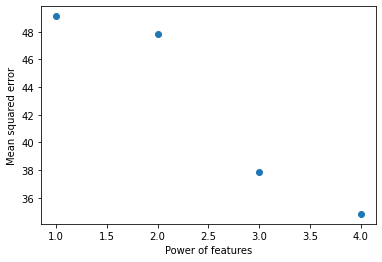

In [62]:
power=list(range(1,5))
plt.figure(6)
plt.scatter(power,mse_all)
plt.xlabel('Power of features')
plt.ylabel('Mean squared error')

Text(0, 0.5, 'r2')

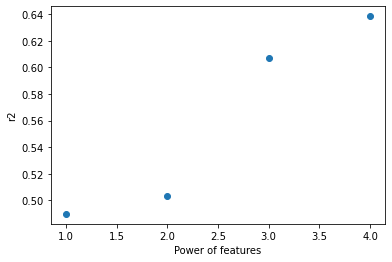

In [63]:
power=list(range(1,5))
plt.figure(7)
plt.scatter(power,r2_all)
plt.xlabel('Power of features')
plt.ylabel('r2')

Text(0, 0.5, 'adj r2')

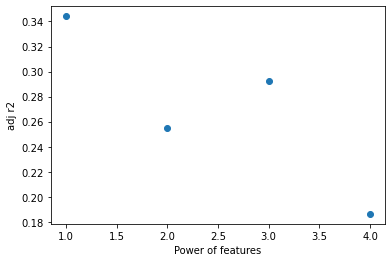

In [64]:
power=list(range(1,5))
plt.figure(8)
plt.scatter(power,adj_r2_all)
plt.xlabel('Power of features')
plt.ylabel('adj r2')

In [65]:
features=['new_deaths', 'new_cases', 'stringency_index', 'total_tests', 'icu_patients_per_million'] #maybe because of collinearity
power_feature=['icu_patients_per_million', 'new_cases']
# SH version
# features=['new_deaths', 'new_cases',
#          'stringency_index','total_tests','hosp_patients_per_million',
#          'hosp_patients','icu_patients_per_million','icu_patients']
# power_feature=['hosp_patients_per_million',
#          'hosp_patients','icu_patients_per_million','icu_patients','new_cases']

all={}
mse_all=[]
r2_all=[]
adj_r2_all=[]
for i in range(1,5):
    print(f"Power: {i}")
    df_feature, df_target = get_features_targets(df_cov_gold, features, ['Close'])
    for f in power_feature:
        df_feature = transform_features(df_feature, f, f+"^",i)

    # Split into training and test data set
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
    
    # Normalize train features
    df_features_train_z=normalize_z(df_features_train)

    # Prepare X and target vector
    X = prepare_feature(df_features_train_z)
    m=X.shape[1]
    target = prepare_target(df_target_train)

    # Set up gradient descent
    iterations = 1500
    alpha = 0.01
    beta = np.zeros((m,1))

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # Call the predict method to get the predicted values
    pred = predict(df_features_test, beta)
    all[i]=pred

    # Collect evaluation metric

    # MSE
    actual=prepare_target(df_target_test)
    mse2=mean_squared_error(actual,pred)
    print("MSE: ",mse2)
    mse_all.append(mse2)
    
    # r_2
    r2 = r2_score(actual,pred)
    print("r2: ",r2)
    r2_all.append(r2)

    #madj r2
    adj_r2=adj_r2_score(df_features_test,actual,pred)
    print('adjusted r2: ',adj_r2)
    print("adj_r2",adj_r2)
    adj_r2_all.append(adj_r2)
    print("_" * 10)
    

Power: 1
MSE:  54.96767016020216
r2:  0.42925378647164114
adjusted r2:  0.29953873794246866
adj_r2 0.29953873794246866
__________
Power: 2
MSE:  54.15337727378205
r2:  0.43770883978339403
adjusted r2:  0.24090693370758198
adj_r2 0.24090693370758198
__________
Power: 3
MSE:  41.43452418216604
r2:  0.5697726005596174
adjusted r2:  0.3546589008394262
adj_r2 0.3546589008394262
__________
Power: 4
MSE:  36.72195557682059
r2:  0.6187046487918696
adjusted r2:  0.35656409483627993
adj_r2 0.35656409483627993
__________


Text(0, 0.5, 'adj r2')

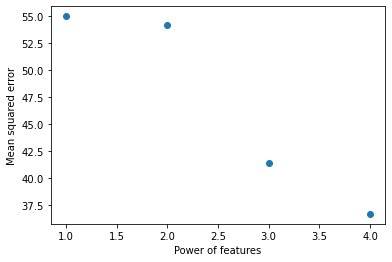

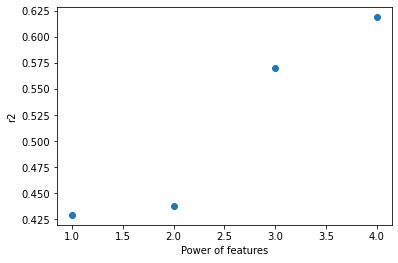

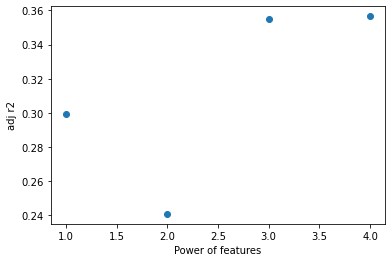

In [66]:
power=list(range(1,5))
plt.figure(6)
plt.scatter(power,mse_all)
plt.xlabel('Power of features')
plt.ylabel('Mean squared error')

power=list(range(1,5))
plt.figure(7)
plt.scatter(power,r2_all)
plt.xlabel('Power of features')
plt.ylabel('r2')

power=list(range(1,5))
plt.figure(8)
plt.scatter(power,adj_r2_all)
plt.xlabel('Power of features')
plt.ylabel('adj r2')